# This notebook is to implement different ways to handle the missing data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from xgboost import XGBClassifier

ROOT = '../..'
DATA = os.path.join(ROOT, 'data')
DATA_RAW = os.path.join(DATA, 'raw')
SRC = os.path.join(ROOT, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp

The only missing data in the datasets is the demographics in the "profile" dataframe.

## Get the initial data (not to be modified)

In [2]:
# Read in the json files
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic preprocessing
data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

In [3]:
print(data.shape)
data.head()

(306534, 20)


,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
event                   306534 non-null object
person                  306534 non-null object
time                    306534 non-null int64
amount                  138953 non-null float64
offer_id                167581 non-null object
reward                  33579 non-null float64
age                     272762 non-null float64
became_member_on        306534 non-null datetime64[ns]
gender                  272762 non-null object
income                  272762 non-null float64
missing_demographics    306534 non-null int64
member_epoch_days       306534 non-null int64
difficulty              167581 non-null float64
duration                167581 non-null float64
offer_type              167581 non-null object
reward_t                167581 non-null float64
channel_email           167581 non-null float64
channel_mobile          167581 non-null float64
channel_social          167581

In [5]:
data.isnull().mean().sort_values(ascending=False)

reward                  0.890456
amount                  0.546696
channel_web             0.453304
channel_mobile          0.453304
channel_email           0.453304
reward_t                0.453304
offer_type              0.453304
duration                0.453304
difficulty              0.453304
offer_id                0.453304
channel_social          0.453304
age                     0.110174
income                  0.110174
gender                  0.110174
became_member_on        0.000000
missing_demographics    0.000000
member_epoch_days       0.000000
time                    0.000000
person                  0.000000
event                   0.000000
dtype: float64

Almost all the missing data is there because the field doesn't make any sense in the kind of event. The only ones that matter are 'age', 'income' and 'gender'; the 'profile' features.

In [6]:
profile.isnull().mean()

age                     0.127941
became_member_on        0.000000
gender                  0.127941
id                      0.000000
income                  0.127941
missing_demographics    0.000000
member_epoch_days       0.000000
dtype: float64

## Basic filling: Median

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
class BasicImputer(BaseEstimator, TransformerMixin):
    """
    Fills the demographics missing data with medians and most frequent values.
    """
    def __init__(self):
        super(BaseEstimator, self).__init__()
        self.age_value = None
        self.income_value = None
        self.gender_value = None
    
    def fit(self, X, y=None):
        """ Get some medians. """
        self.age_value = X.age.median().round()
        self.income_value = X.income.median()
        self.gender_value = X.gender.mode().values[0]
        return self

    def transform(self, X):
        """ Encode offer types and gender """
        return X.fillna({'age': self.age_value,
                         'income': self.income_value,
                         'gender': self.gender_value})

In [9]:
from sklearn.pipeline import Pipeline

In [10]:
encoder_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', BasicImputer())
])

In [11]:
%time filled = encoder_imputer.fit_transform(data)

CPU times: user 2 s, sys: 165 ms, total: 2.16 s
Wall time: 1.19 s


In [12]:
filled.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,0.0,100000.0,0.0,17295.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,55.0,2017-08-04,1.0,62000.0,1.0,17382.0,20.0,10.0,1.0,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,1.0,70000.0,0.0,17647.0,10.0,7.0,1.0,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,55.0,2017-09-25,1.0,62000.0,1.0,17434.0,10.0,10.0,1.0,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,55.0,2017-10-02,1.0,62000.0,1.0,17441.0,10.0,5.0,0.0,10.0,1.0,1.0,1.0,1.0


In [13]:
def add_bar_labels(values):
    for i, v in enumerate(values):
            plt.text(i, v, str(v), ha='center', fontweight='bold')

In [14]:
def show_imputer_results(data, filled, 
                         continuous=['age', 'income'],
                         discrete=['gender']):
    """ Shows some differences between a dataset and a filled dataset. """
    for feat in continuous:
        plt.figure()
        ax1 = plt.subplot(1,2,1)
        data[feat].hist(bins=30)
        plt.title('{} original'.format(feat))
        plt.subplot(1,2,2, sharey=ax1)
        filled[feat].hist(bins=30)
        plt.title('{} filled'.format(feat))
    
    for feat in discrete:
        counts1 = data.gender.value_counts(dropna=False)
        counts2 = filled.gender.value_counts(dropna=False)
        plt.figure()
        ax1 = plt.subplot(1,2,1)
        counts1.plot(kind='bar')
        plt.title('{} original'.format(feat))
        add_bar_labels(counts1)
        plt.subplot(1,2,2, sharey=ax1)
        counts2.plot(kind='bar')
        plt.title('{} filled'.format(feat))
        add_bar_labels(counts2)

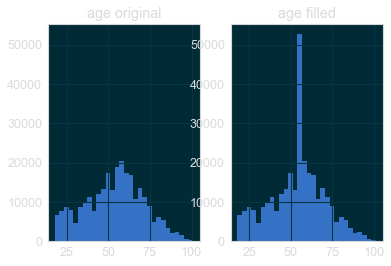

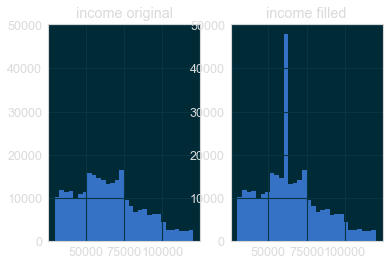

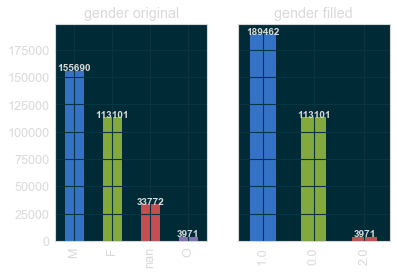

In [15]:
show_imputer_results(data, filled)

## Filling by fitting an estimator.

All the (relevant) missing data is in the profile dataframe. The problem is that when a customer has one feature missing it has almost all of them. That makes it difficult to estimate the missing data but, in the worst case, the imputed missing data will at least follow the distribution of the rest of the data.

In [16]:
profile.head()

,age,became_member_on,gender,id,income,missing_demographics,member_epoch_days
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1,17209
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,17362
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1,17724
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,17295
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1,17382


In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
age                     14825 non-null float64
became_member_on        17000 non-null datetime64[ns]
gender                  14825 non-null object
id                      17000 non-null object
income                  14825 non-null float64
missing_demographics    17000 non-null int64
member_epoch_days       17000 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 929.8+ KB


Let's generate some features from the 'became_member_on' feature, which is the only one that is relevant and never is missing.

In [18]:
def add_date_features(data):
    """ Generates some features from the date the customer became member on,"""
    data['member_day'] = data.became_member_on.dt.day
    data['member_weekday'] = data.became_member_on.dt.weekday
    data['member_year'] = data.became_member_on.dt.year
    data['member_month'] = data.became_member_on.dt.month
    
    return data

In [19]:
data = add_date_features(data)
data.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,...,offer_type,reward_t,channel_email,channel_mobile,channel_social,channel_web,member_day,member_weekday,member_year,member_month
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,...,bogo,5.0,1.0,1.0,0.0,1.0,9,1,2017,5
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,...,discount,5.0,1.0,0.0,0.0,1.0,4,4,2017,8
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,...,discount,2.0,1.0,1.0,0.0,1.0,26,3,2018,4
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,...,discount,2.0,1.0,1.0,1.0,1.0,25,0,2017,9
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,...,bogo,10.0,1.0,1.0,1.0,1.0,2,0,2017,10


In [20]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [21]:
from xgboost import XGBClassifier, XGBRegressor

In [22]:
MEMBER_DATE_FEATS = ['member_epoch_days', 'member_day', 'member_month',
                     'member_year', 'member_weekday']

class EstimatorImputer(BaseEstimator, TransformerMixin):
    """
    Fills the demographics missing data with predictions from an estimator.
    """
    def __init__(self, features=MEMBER_DATE_FEATS, add_date_feats=True):
        super(BaseEstimator, self).__init__()
        self.features = features
        self.age_estimator = XGBRegressor(max_depth=7, n_estimators=200, 
                                          random_state=2018)
        self.income_estimator = XGBRegressor(max_depth=7, n_estimators=200,
                                             random_state=2018)
        self.gender_estimator = XGBClassifier(max_depth=7, n_estimators=200,
                                              random_state=2018)
    
    def fit(self, X, y=None):
        """ Fit the estimators """
        X = add_date_features(X)
        X_age_clean = X[~X.age.isnull()]
        self.age_estimator.fit(X_age_clean[self.features], X_age_clean.age)
        X_income_clean = X[~X.age.isnull()]
        self.income_estimator.fit(X_income_clean[self.features], 
                                  X_income_clean.income)
        X_gender_clean = X[~X.age.isnull()]
        self.gender_estimator.fit(X_gender_clean[self.features], 
                                  X_gender_clean.gender)
        return self

    def transform(self, X):
        """ Fill the missing data. """
        res = X.copy()
        res = add_date_features(res)

        # Fill the age values
        age_missing = res[res.age.isnull()]
        age_missing_index = res.index[res.age.isnull()]
        age_values = self.age_estimator.predict(age_missing[self.features])
        res.update(pd.DataFrame(age_values, index=age_missing_index, 
                                columns=['age']))
        
        # Fill the income values
        income_missing = res[res.income.isnull()]
        income_missing_index = res.index[res.income.isnull()]
        income_values = self.income_estimator.predict(
            income_missing[self.features])
        res.update(pd.DataFrame(income_values, index=income_missing_index, 
                                columns=['income']))
        
        # Fill the gender values
        gender_missing = res[res.gender.isnull()]
        gender_missing_index = res.index[res.gender.isnull()]
        gender_values = self.gender_estimator.predict(gender_missing[self.features])
        res.update(pd.DataFrame(gender_values, index=gender_missing_index, 
                                columns=['gender']))
        return res

In [23]:
# Read in the json files
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic preprocessing
data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

In [24]:
# Now, let's imput the missing data.

In [25]:
encoder_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', EstimatorImputer())
])

In [26]:
%time filled = encoder_imputer.fit_transform(data)

CPU times: user 5min 29s, sys: 4.12 s, total: 5min 33s
Wall time: 5min 49s


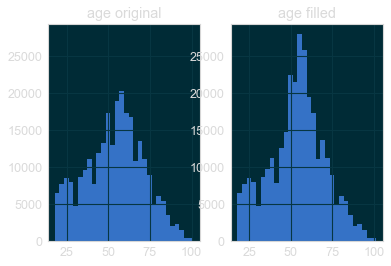

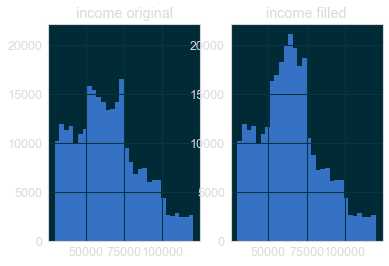

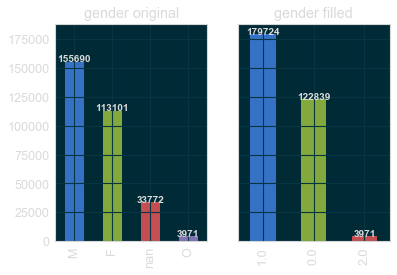

In [27]:
show_imputer_results(data, filled)

That looks better than the BasicImputer, although it takes longer than it. I could use a metric like RMSE or accuracy to see if there is an improvement.

## Missing data imputers evaluation

In [28]:
estimator_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', EstimatorImputer())
])

basic_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', BasicImputer())
])

### Let's generate a clean dataset and some fake missing ages, incomes, and genders.

In [29]:
data.shape

(306534, 20)

In [30]:
clean_data = data[data.missing_demographics == 0]
clean_data.shape

(272762, 20)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
target_feats = ['age', 'income', 'gender']
X = clean_data.drop(target_feats, axis=1)
y = clean_data[target_feats]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2018)

In [33]:
data_train = X_train.join(y_train)
print(data_train.shape)
data_train.head()

(190933, 20)


,event,person,time,amount,offer_id,reward,became_member_on,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_email,channel_mobile,channel_social,channel_web,age,income,gender
52221,transaction,cf6b9d5cec40472eb455cea78fa4a94d,156,1.56,NaN,NaN,2016-02-28,0,16859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,54000.0,F
229992,transaction,9bde4015093a4b4885cbc6aecc44ec19,528,26.02,NaN,NaN,2016-04-28,0,16919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,79000.0,M
134019,transaction,da3d478411cd4a30a6efa9d673530f00,354,4.99,NaN,NaN,2017-05-23,0,17309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,30000.0,M
218627,transaction,9e116eeee25949e7b1a3f91227db7422,510,23.28,NaN,NaN,2017-08-06,0,17384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,63000.0,F
108864,transaction,3622ada8c6394b32a8d7ba31c737e926,318,26.71,NaN,NaN,2015-08-12,0,16659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,111000.0,M


In [34]:
X_input = data_train.append(X_test, sort=False).sort_values(by='time')

In [35]:
X_input.head()

,event,person,time,amount,offer_id,reward,became_member_on,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_email,channel_mobile,channel_social,channel_web,age,income,gender
3849,offer received,c9c0e595d6b84dfc8bee2592160bee11,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,2013-10-08,0,15986,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,28.0,40000.0,M
6560,offer received,0cf2ddcf6c034ac9906831614a360d0d,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,2018-02-09,0,17571,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,77.0,63000.0,O
15267,transaction,64763980a84b4d7d898a734898b82f93,0,11.11,NaN,NaN,2015-10-26,0,16734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15147,transaction,4fa7957dda024f56b6d211dd8cca6c4d,0,26.47,NaN,NaN,2017-10-14,0,17453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4237,offer received,2b5f2abb89e44c208bb88e64cce13f43,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2016-09-14,0,17058,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN


### Let's test both imputers now

In [36]:
%time X_out_basic = basic_imputer.fit_transform(X_input)

CPU times: user 2.19 s, sys: 142 ms, total: 2.33 s
Wall time: 1.27 s


In [37]:
%time X_out_estimator = estimator_imputer.fit_transform(X_input)

CPU times: user 3min 52s, sys: 3.51 s, total: 3min 55s
Wall time: 4min


### Evaluation

In [38]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

In [39]:
age_true = y_test.age
income_true = y_test.income
gender_true = pp.gender_encode(y_test.loc[:, ['gender']])

In [40]:
print('Basic Imputer\n')

age_basic_pred = X_out_basic.loc[y_test.index, :].age
income_basic_pred = X_out_basic.loc[y_test.index, :].income
gender_basic_pred = X_out_basic.loc[y_test.index, :].gender

print('Age RMSE: {}'.format(np.sqrt(mse(age_true, age_basic_pred))))
print('Income RMSE: {}'.format(np.sqrt(mse(income_true, income_basic_pred))))
print('Gender Accuracy: {}'.format(np.sqrt(accuracy_score(gender_true, 
                                                          gender_basic_pred))))
print('-'*100)

Basic Imputer

Age RMSE: 17.572404915399257
Income RMSE: 21320.43274676904
Gender Accuracy: 0.7557961393945133
----------------------------------------------------------------------------------------------------


In [41]:
print('Estimator Imputer\n')

age_est_pred = X_out_estimator.loc[y_test.index, :].age
income_est_pred = X_out_estimator.loc[y_test.index, :].income
gender_est_pred = X_out_estimator.loc[y_test.index, :].gender

print('Age RMSE: {}'.format(np.sqrt(mse(age_true, age_est_pred))))
print('Income RMSE: {}'.format(np.sqrt(mse(income_true, income_est_pred))))
print('Gender Accuracy: {}'.format(np.sqrt(accuracy_score(gender_true, 
                                                          gender_est_pred))))
print('-'*100)

Estimator Imputer

Age RMSE: 16.44607102133572
Income RMSE: 19816.1628882959
Gender Accuracy: 0.8022609778352745
----------------------------------------------------------------------------------------------------


### Effectively, the Estimator Imputer gives better results in all the features, but it takes much longer to process the data.